In [1]:
#import insulin dataset
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt


InsulinDataP1 = pd.read_csv("InsulinData.csv", parse_dates=True, low_memory=False)
#InsulinDataP2 = pd.read_excel("InsulinAndMealIntake670GPatient2.xlsx", parse_dates=False)

In [2]:
#print(InsulinDataP1.head())
#print(InsulinDataP2.head())

In [3]:
#make it pretty
def getListOfMealTimes(insulindf):
    potentialMeals = insulindf.loc[:,['Date', 'Time', 'BWZ Carb Input (grams)']]
    potentialMeals = potentialMeals.rename(columns = {"BWZ Carb Input (grams)" : "carbs"})
    
    print(len(potentialMeals))
    potentialMeals = potentialMeals.dropna()
    print(len(potentialMeals))
    potentialMeals = potentialMeals.loc[(potentialMeals!=0).all(1)]
    print(len(potentialMeals))
    
    carbList = potentialMeals['carbs'].to_list()

    
    #combine the date and time column into a actual datetime64 column to index by
    datesList = potentialMeals['Date'].to_list()
    timesList = potentialMeals['Time'].to_list()
    datetimeList = []
    for i in range(len(datesList)):
        datetimeList.append(pd.to_datetime(datesList[i] + ":" + timesList[i], format='%m/%d/%Y:%H:%M:%S'))
 
        
    potentialMeals = pd.DataFrame({'datetime' : datetimeList[::-1], 'carbs' : carbList[::-1]})
    meals = pd.DataFrame(columns = ['datetime', 'carbs'])
    mealsWithCarbs = pd.DataFrame(columns = ['datetime', 'carbs'])                 
    #remove meals that happen before t+2hours
    #iterate from beginning to end comparing each value to the next one
    dropped = 0
    for i in range(len(potentialMeals) - 1):  
        mealsWithCarbs = mealsWithCarbs.append(potentialMeals.iloc[i])
        thisMealTime = potentialMeals.iloc[i]['datetime']
        nextMealTime = potentialMeals.iloc[i+1]['datetime']
        
        if (nextMealTime - thisMealTime <= pd.Timedelta(2,unit='h')):
            dropped = dropped + 1
        else:
            
            if(potentialMeals.iloc[i]['carbs'] >= 60):
                meals = meals.append(potentialMeals.iloc[i])
            

    #if the next meal is <2hrs after that one then skip adding this current one
    #print("these are the after meals")
    #print(meals.head(30))
    return meals, mealsWithCarbs

p1mealTimes, p1mealTimesAllCarbs = getListOfMealTimes(InsulinDataP1)
#p2mealTimes = getListOfMealTimes(InsulinDataP2)
print(len(p1mealTimes))
print(len(p1mealTimesAllCarbs))
#print(len(p2mealTimes))


41435
1040
747
140
746


In [4]:
#import CGM dataset
CGMdataFilePerson1 = pd.read_csv("CGMData.csv", parse_dates=True, low_memory=False)
#CGMdataFilePerson2 = pd.read_excel("CGMData670GPatient2.xlsx", parse_dates=True, low_memory=False)

In [5]:
#make it pretty
def makeCGMpretty(cgmdf):
    #remove most columns
    GGMdata = cgmdf.loc[:,['Date', 'Time', 'Sensor Glucose (mg/dL)']]

    #rename the senosr glucose to something nicer
    GGMdata = GGMdata.rename(columns = {"Sensor Glucose (mg/dL)" : "sg"})

    #combine the date and time column into a actual datetime64 column to index by
    datesList = GGMdata.iloc[:]['Date']
    timesList = GGMdata.iloc[:]['Time']
    datetimeList = []
    for i in range(len(datesList)):
        datetimeList.append(pd.to_datetime(datesList[i] + ":" + timesList[i], format='%m/%d/%Y:%H:%M:%S'))
    GGMdata.insert(0,"datetime",datetimeList,True)
    GGMdata = GGMdata.drop(columns=['Date', 'Time'])
    GGMdata.set_index('datetime', inplace=True)
    return GGMdata

p1cgmdf = makeCGMpretty(CGMdataFilePerson1)
#p2cgmdf = makeCGMpretty(CGMdataFilePerson2)

In [6]:
listOfDays = [group[1] for group in p1cgmdf.groupby(p1cgmdf.index.date)]

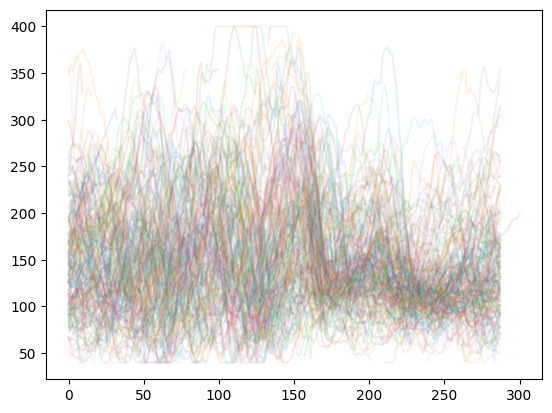

In [7]:
import matplotlib.pyplot as plt
for i in range(len(listOfDays)):
    plt.plot(listOfDays[i]['sg'].to_list(),alpha=0.1)


plt.show()

In [8]:
#create list of meals

p1MealsCGM = []
thirtyMinutes = pd.Timedelta(30,unit='m')
twoHours = pd.Timedelta(2,unit='h')

for i,d  in p1mealTimes.iterrows():
    mealTime = d['datetime'] 
    startTime = mealTime - thirtyMinutes
    endTime = mealTime + twoHours
    
    sData = p1cgmdf.loc[(p1cgmdf.index > startTime) & (p1cgmdf.index <= endTime)].dropna()
    #print(len(sData))
    #print(startTime)
    #print(endTime)
    #print(sData)
    if(len(sData) == 30):
        p1MealsCGM.append(sData['sg'].to_list())

print(len(p1MealsCGM))
#print(p1MealsCGM)

#iterate over meal times
#save cgm data frames with a query of t-30 and t + 2 hrs and check if there is 24 values

107


In [9]:
#create list of non meals
#iterate over meal times
#compare this meal to the next one
#calculate the time between t + 2hrs and t+1 - 2 hrs
#if it's grater than 2 hrs long
#grab it and save it into 2 hour sections
twoHours = pd.Timedelta(2,unit='h')
p1NoMealsCGM = []
for i in range(len(p1mealTimesAllCarbs)-1):
    thisMealTime = p1mealTimesAllCarbs.iloc[i]['datetime'] + twoHours
    nextMealTime = p1mealTimesAllCarbs.iloc[i+1]['datetime'] - twoHours
    between = nextMealTime - thisMealTime
    
    if(between > pd.Timedelta(10,unit='h')):
        continue
    
    ite = 1
    while (between > twoHours):
        ite = ite + 1
        sData = p1cgmdf.loc[(p1cgmdf.index > thisMealTime + pd.Timedelta((2 * ite),unit='h')) & (p1cgmdf.index <= thisMealTime + pd.Timedelta((2 * ite) + 2,unit='h'))].dropna()
        if(len(sData) == 24):
            #print(between)
            #print(sData)
            p1NoMealsCGM.append(sData['sg'].to_list())
        between = between - twoHours
    
    
#print(p1NoMealsCGM)
print(len(p1NoMealsCGM))

356


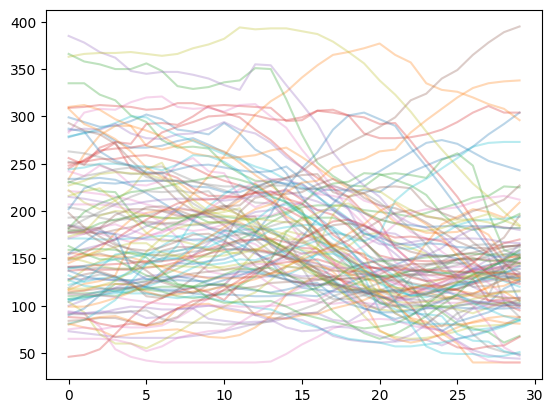

In [10]:
for i in range(0,100):
    plt.plot(p1MealsCGM[i],alpha=0.3)


plt.show()

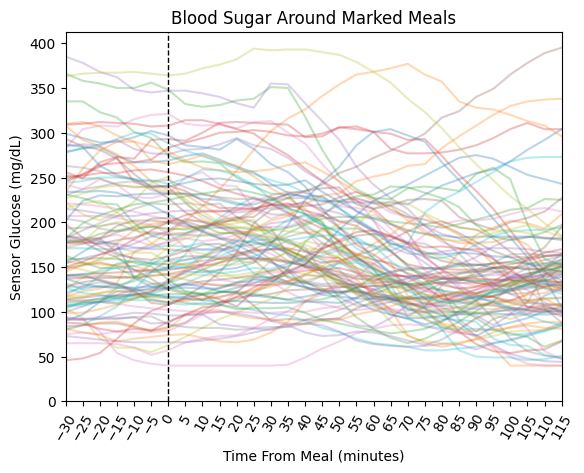

In [36]:
xlabels = [(x*5)-30 for x in range(30)]

for i in range(0,100):
    plt.plot(xlabels, p1MealsCGM[i],alpha=0.3)

#put a vertical line at meal time
# title it 
plt.title("Blood Sugar Around Marked Meals")
# label y axis Sensor Glucose (mg/dL)
plt.ylabel("Sensor Glucose (mg/dL)")
# change the x label to Time From Meal (minutes)
plt.xlabel("Time From Meal (minutes)")
#change numbers to (index * 5) - 30
plt.xticks(xlabels, rotation=60)
plt.ylim(ymin=0)
plt.xlim(xmin=-30,xmax=115)
plt.axvline(0, color='k', linestyle='dashed', linewidth=1)
plt.show()

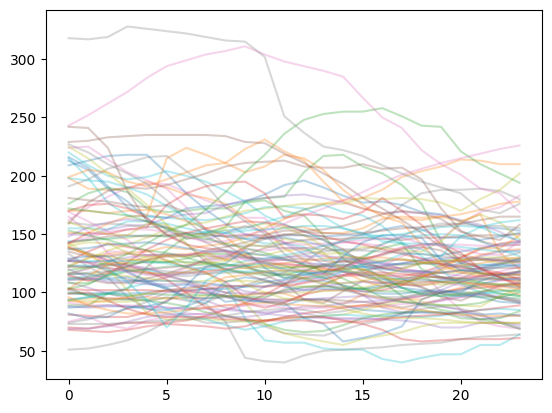

In [13]:
for i in range(100,200):
    plt.plot(p1NoMealsCGM[i],alpha=0.3)


plt.show()

In [14]:
#shorten meals to 2 hours
p1MealsCGMShort = []
for m in p1MealsCGM:
    p1MealsCGMShort.append(m[:-6])


In [15]:
def extractFeatures(sglist):
    features = []
    #min max diffrence
    #features.append(max(sglist) - min(sglist))
    #time between min and max
    #features.append(sglist.index(max(sglist)) - sglist.index(min(sglist)))
    #start - end
    features.append((sglist[0]-sglist[23]))
    
    #fft
    #features.append(sum(abs(np.fft.fft(sglist)))/len(sglist))
        
    #integrate
    integrated = []
    for i in range(23):
        integrated.append(sglist[i]-sglist[i+1])
    
    integratedSquared = [x ** 2 for x in integrated]

    #max speed
    features.append(max(integrated))
    
    #average velocity
    features.append(sum(integrated)/len(integrated))
    
    #average squared velocity 
    features.append(sum(integratedSquared)/len(integratedSquared))
    
    return features

In [16]:
p1MealsCGMShortFeatures = [extractFeatures(x) for x in p1MealsCGMShort]
p1NoMealsCGMFeatures = [extractFeatures(x) for x in p1NoMealsCGM]

mealsF1List = [x[1] for x in p1MealsCGMShortFeatures]
noMealsF1List = [x[1] for x in p1NoMealsCGMFeatures]
#print(mealsF1List)
#print(noMealsF1List)

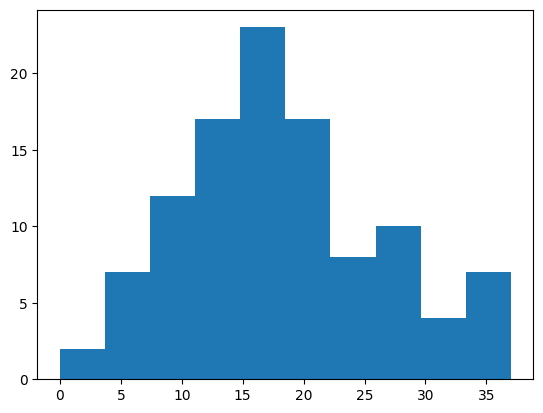

In [17]:
plt.hist(mealsF1List)
plt.show()

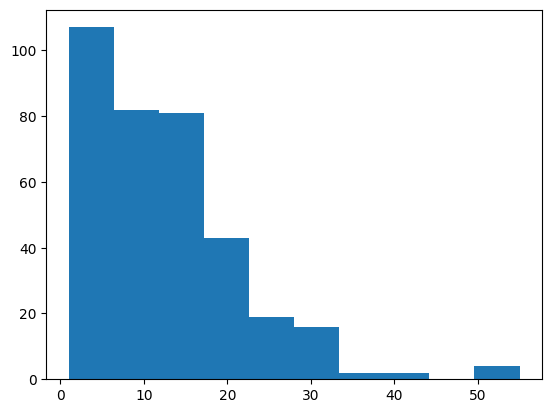

In [18]:
plt.hist(noMealsF1List)
plt.show()

In [19]:
from sklearn.model_selection import train_test_split

#generate x and y sets
#xList = p1MealsCGMShort + p1NoMealsCGM[100:200]
xList = p1MealsCGMShortFeatures + p1NoMealsCGMFeatures[:100]
yList = [1] * len(p1MealsCGMShort) + [0] * 100#len(p1NoMealsCGM)
#print(xList)
xal = [np.array(xi) for xi in xList]
X = np.stack(xal, axis=0)
y = np.array(yList)

print(x.shape)
print(y.shape)



NameError: name 'x' is not defined

In [ ]:
import csv 

with open('test.csv', 'w') as f: 
    write = csv.writer(f) 
      
    write.writerows(p1MealsCGMShort + p1NoMealsCGM) 

In [ ]:
#train model and evaluate
from sklearn import svm
from sklearn.model_selection import KFold

#generate test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


#clf = svm.SVC(kernel='sigmoid')
#clf = svm.SVC(kernel='poly', degree=4)
#clf = svm.SVC(kernel='linear')
#clf = svm.SVC(kernel='rbf')
clf = svm.SVC()

clf.fit(X_train, y_train)

from sklearn import metrics

#evaluate model
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7380952380952381
[[10  7]
 [ 4 21]]
              precision    recall  f1-score   support

           0       0.71      0.59      0.65        17
           1       0.75      0.84      0.79        25

    accuracy                           0.74        42
   macro avg       0.73      0.71      0.72        42
weighted avg       0.74      0.74      0.73        42



In [ ]:
#train model and evaluate
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

kf = KFold(n_splits=5,shuffle = True)

models = []
accuracy_model = []


#clf = svm.SVC(kernel='sigmoid')
#clf = svm.SVC(kernel='poly', degree=4)
#clf = svm.SVC(kernel='linear')
#clf = svm.SVC(kernel='rbf')
clf = svm.SVC()

# Iterate over each train-test split
for train_index, test_index in kf.split(X):
    # Split train-test
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Train the model
    model = clf.fit(X_train, y_train)
    models.append(model)
    # Append to accuracy_model the accuracy of the model
    accuracy_model.append(accuracy_score(y_test, model.predict(X_test), normalize=True)*100)

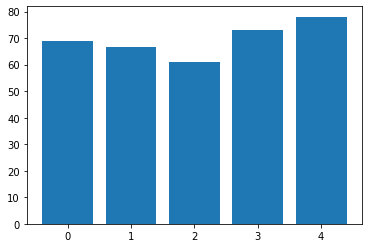

In [ ]:
plt.bar(range(len(accuracy_model)), accuracy_model)
plt.show()

In [ ]:
import pickle

#save model object
filename = 'model.pickle'
pickle.dump(clf, open(filename, 'wb'))